<a href="https://colab.research.google.com/github/anazantoro/FoodContent_Multilabel_Classification/blob/main/FoodContent_Multilabel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import pandas as pd

from collections import Counter

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from keras.callbacks import Callback
from keras.backend import clear_session
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten
from keras.applications import ResNet50, MobileNet, Xception, DenseNet121

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
## Downloading file from Google Drive

download = drive.CreateFile({'id': '1XOAD_0Z9wDej-Whd1IYhp0YtHdKudgD4'})
download.GetContentFile('data.tar.gz')

In [ ]:
!tar -xzvf data.tar.gz

Streaming output truncated to the last 5000 lines.
data/nanonets/multilabel_data/ImageSets/13_lobster_rolls_(bay_seafood_seasoning)_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/18_peach_melba_frozen_yogurt_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/29_roasted_beet_and_basil_salad_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/17_spicy_baby_back_ribs_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/18_apple_pie_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/16_hot_and_sour_soup_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/10_potato_samosas_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/17_macaroni_&_cheese_dinner_fiesta_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/32_spicy_shrimp_fried_rice_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/0_chocolate_mousse_hostedLargeUrl.jpg
data/nanonets/multilabel_data/ImageSets/23_onion_rings_hostedLargeUrl.jpg
data/nanonets/multilabel_d

In [ ]:
cd ./data/keras

/content/data/keras


In [ ]:
def load_data(df):

    trainX, testX, valX = [], [], []
    trainY, testY, valY = [], [], []

    for i in range(len(df)):

        item = df.loc[i][0]
        current_label = np.array((df.loc[i])[1:])

        path = os.path.join('images', item)
        list_of_imgs = [os.path.join(path, file) for file in os.listdir(path)]
        train_set = list_of_imgs[:30]
        val_set = list_of_imgs[30:40]
        test_set = list_of_imgs[40:]

        for file in train_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            trainX.append(img)
            trainY.append(current_label)

        for file in val_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            valX.append(img)
            valY.append(current_label)

        for file in test_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            testX.append(img)
            testY.append(current_label)

    return (np.array(trainX), np.array(trainY), np.array(testX),
            np.array(testY), np.array(valX), np.array(valY))

In [ ]:
df = pd.read_csv('clean_anno_reduced.csv')
trainX, trainY, testX, testY, valX, valY = load_data(df)

In [ ]:
## Normalization

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
valX = valX.astype(np.float32)

trainY = trainY.astype(np.float32)
testY = testY.astype(np.float32)
valY = valY.astype(np.float32)

MEAN = np.mean(trainX, axis = (0,1,2))
STD = np.std(trainX, axis = (0,1,2))

for i in range(3):
    trainX[:, :, :, i] = (trainX[:, :, :, i] - MEAN[i]) / STD[i]
    testX[:, :, :, i] = (testX[:, :, :, i] - MEAN[i]) / STD[i]
    valX[:, :, :, i] = (valX[:, :, :, i] - MEAN[i]) / STD[i]

In [ ]:
MEAN, STD

(array([51.072815, 51.072815, 51.072815], dtype=float32),
 array([108.75478,  92.7417 ,  85.36711], dtype=float32))

In [ ]:
clear_session()
img = Input(shape = (224, 224, 3))

base_model = DenseNet121(include_top=False,
                    weights='imagenet',
                    input_tensor=img,
                    input_shape=None,
                    pooling='avg')
final_layer = base_model.layers[-1].output

dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
output_layer = Dense(10, activation = 'sigmoid')(dense_layer_1)

model = Model(inputs = img, outputs = output_layer) # Use inputs and outputs instead of input and output

In [ ]:
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
## Custom callback to compute F1 Score and save the model
## with best validation F1 Score.

class ComputeF1(Callback):

    def __init__(self, validation_data):
        self.best_f1 = -1
        # Store validation data here
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs={}):
        val_pred = np.round(self.model.predict(self.validation_data[0]))
        val_f1 = f1_score(self.validation_data[1], val_pred, average='samples')
        print('Validation Average F1 Score: ', val_f1)

        if val_f1 > self.best_f1:
            print('Better F1 Score, Saving model...')
            self.model.save('model.h5')
            self.best_f1 = val_f1

# Initialize the callback with validation data
f1_score_callback = ComputeF1(validation_data=(valX, valY))

# Pass validation data to the callback when fitting the model
model.fit(trainX,
          trainY,
          batch_size = 32,
          epochs = 25,
          validation_data = (valX, valY),
          callbacks = [f1_score_callback])

Epoch 1/25
17/17 [==============================] - 3s 88ms/step
Validation Average F1 Score:  0.2844698295985061
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 109s 700ms/step - loss: 0.5147 - accuracy: 0.0650 - val_loss: 1.6923 - val_accuracy: 0.0478
Epoch 2/25
17/17 [==============================] - 2s 98ms/step
Validation Average F1 Score:  0.36228116246498604
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 26s 491ms/step - loss: 0.4599 - accuracy: 0.0662 - val_loss: 1.4146 - val_accuracy: 0.1783
Epoch 3/25
17/17 [==============================] - 2s 92ms/step
Validation Average F1 Score:  0.5093793767507002
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 25s 466ms/step - loss: 0.3978 - accuracy: 0.1128 - val_loss: 0.6937 - val_accuracy: 0.1048
Epoch 4/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.5766855795348442
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 25s 464ms/step - loss: 0.3717 - accuracy: 0.1080 - val_loss: 0.9240 - val_accuracy: 0.0184
Epoch 5/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.49182714752567697
53/53 [==============================] - 23s 431ms/step - loss: 0.3360 - accuracy: 0.1211 - val_loss: 1.6541 - val_accuracy: 0.0901
Epoch 6/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6521321407350819
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 26s 502ms/step - loss: 0.2969 - accuracy: 0.1527 - val_loss: 0.7214 - val_accuracy: 0.1158
Epoch 7/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6219035151939564
53/53 [==============================] - 24s 448ms/step - loss: 0.2572 - accuracy: 0.1856 - val_loss: 0.8741 - val_accuracy: 0.0827
Epoch 8/25
17/17 [==============================] - 2s 92ms/step
Validation Average F1 Score:  0.6346211590696884
53/53 [==============================] - 23s 432ms/step - loss: 0.2245 - accuracy: 0.1742 - val_loss: 0.8152 - val_accuracy: 0.0699
Epoch 9/25
17/17 [==============================] - 2s 94ms/step
Validation Average F1 Score:  0.652662125456243
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 26s 499ms/step - loss: 0.2199 - accuracy: 0.2130 - val_loss: 0.7308 - val_accuracy: 0.1507
Epoch 10/25
17/17 [==============================] - 2s 92ms/step
Validation Average F1 Score:  0.6769760366267719
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 24s 455ms/step - loss: 0.1988 - accuracy: 0.2094 - val_loss: 0.6035 - val_accuracy: 0.0643
Epoch 11/25
17/17 [==============================] - 2s 94ms/step
Validation Average F1 Score:  0.6687278509888804
53/53 [==============================] - 25s 467ms/step - loss: 0.1420 - accuracy: 0.2142 - val_loss: 0.6807 - val_accuracy: 0.0533
Epoch 12/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6776294987692046
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 25s 476ms/step - loss: 0.1273 - accuracy: 0.2315 - val_loss: 0.6522 - val_accuracy: 0.1066
Epoch 13/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6752208269671506
53/53 [==============================] - 23s 431ms/step - loss: 0.1209 - accuracy: 0.2130 - val_loss: 0.9452 - val_accuracy: 0.1158
Epoch 14/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6839852039300569
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 25s 477ms/step - loss: 0.1099 - accuracy: 0.2321 - val_loss: 0.8097 - val_accuracy: 0.1893
Epoch 15/25
17/17 [==============================] - 2s 91ms/step
Validation Average F1 Score:  0.6887136862320685
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 26s 491ms/step - loss: 0.0896 - accuracy: 0.3043 - val_loss: 0.7556 - val_accuracy: 0.1452
Epoch 16/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6447835763093115
53/53 [==============================] - 25s 468ms/step - loss: 0.0846 - accuracy: 0.2780 - val_loss: 0.9016 - val_accuracy: 0.0846
Epoch 17/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.5628741458704694
53/53 [==============================] - 25s 470ms/step - loss: 0.0866 - accuracy: 0.2589 - val_loss: 2.2480 - val_accuracy: 0.2040
Epoch 18/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6695981612341906
53/53 [==============================] - 24s 448ms/step - loss: 0.0851 - accuracy: 0.1927 - val_loss: 0.8579 - val_accuracy: 0.1048
Epoch 19/25
17/17 [==============================] - 2s 92ms/step
Validation Average F1 Score:  0.6204134305237247
53/53 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 26s 488ms/step - loss: 0.0697 - accuracy: 0.2041 - val_loss: 0.7485 - val_accuracy: 0.1029
Epoch 23/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.6981121615312792
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 25s 475ms/step - loss: 0.0403 - accuracy: 0.2088 - val_loss: 0.7291 - val_accuracy: 0.1103
Epoch 24/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.7021922215856039
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 26s 494ms/step - loss: 0.0307 - accuracy: 0.2667 - val_loss: 0.7556 - val_accuracy: 0.1048
Epoch 25/25
17/17 [==============================] - 2s 93ms/step
Validation Average F1 Score:  0.7260075810627282
Better F1 Score, Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 24s 457ms/step - loss: 0.0316 - accuracy: 0.2548 - val_loss: 0.7512 - val_accuracy: 0.1066


In [ ]:
## Loading best model based on validation score

from keras.models import load_model
model = load_model('/content/drive/MyDrive/multilabel_classification/model.h5')

In [ ]:
def F1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='samples')

In [ ]:
F1_score(testY, model.predict(testX).round())

16/16 [==============================] - 7s 377ms/step


0.7398362998167303

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 27ms/step
       Label  Probability (%)
0  Appetizer        99.911430
1      Carbs        99.699715
2       Junk        67.585281
3      Mains         1.886884
4      Soups         0.167169
5    Protein         0.130903
6    Healthy         0.067465
7       Meat         0.014842
8       Fats         0.014768
9    Dessert         0.012944

Predicted label: Appetizer


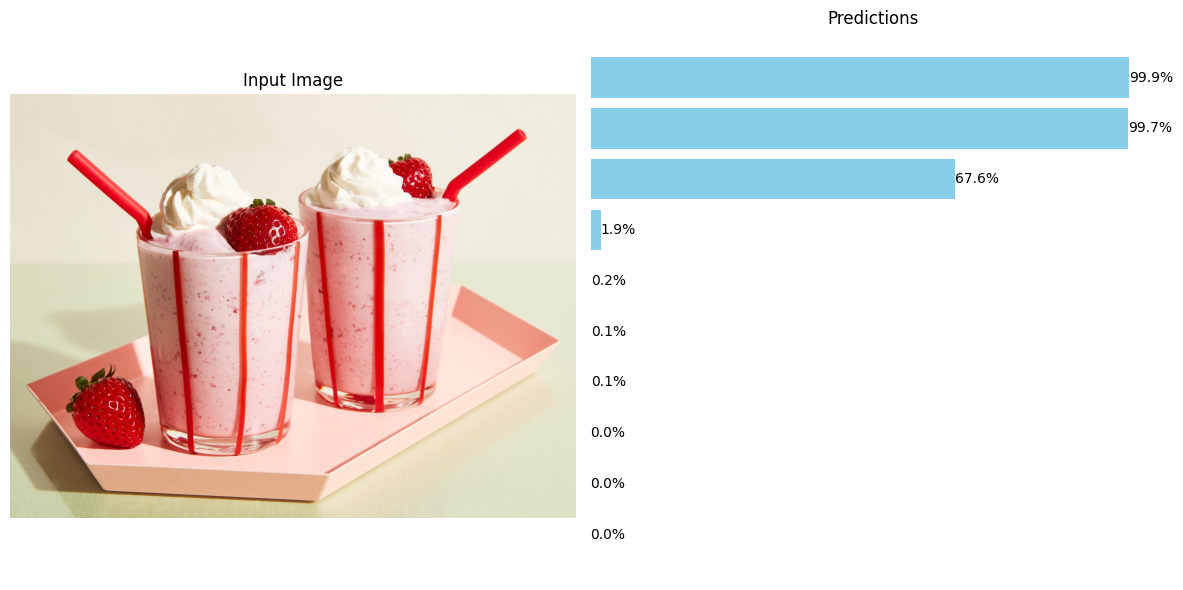

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Define your labels
labels = ["Soups", "Mains", "Appetizer", "Dessert", "Protein", "Fats", "Carbs", "Healthy", "Junk", "Meat"]

# Load image from the URL
def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        return image
    else:
        raise Exception("Could not load image. Status code: {}".format(response.status_code))

# Preprocess the image
def preprocess_image(image, target_size):
    # Resize image to target size
    image = image.resize(target_size)
    image_array = np.array(image)  # Convert image to array
    if len(image_array.shape) == 2:  # If the image is grayscale
        image_array = np.stack((image_array,) * 3, axis=-1)  # Convert to RGB by stacking
    image_array = image_array / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image_array, axis=0)  # Add batch dimension

target_size = (224, 224)  # Example size, adjust to your model's input size

# Load and preprocess the image
url = 'https://assets.epicurious.com/photos/647df8cad9749492c4d5d407/4:3/w_4886,h_3664,c_limit/StrawberryMilkshake_RECIPE_053123_3599.jpg'
image = load_image_from_url(url)
preprocessed_image = preprocess_image(image, target_size)

# Make the prediction
predictions = model.predict(preprocessed_image)

# Convert predictions to percentages
predictions_percentage = predictions[0] * 100  # Convert to percentage

# Create a DataFrame from the predictions
prediction_df = pd.DataFrame({
    'Label': labels,
    'Probability (%)': predictions_percentage
})

# Sort the DataFrame by Probability in descending order
prediction_df = prediction_df.sort_values(by='Probability (%)', ascending=False).reset_index(drop=True)

# Output the DataFrame
print(prediction_df)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)  # Get the predicted class index
predicted_label = labels[predicted_class_index]  # Get corresponding label

# Output the predicted class
print("\nPredicted label:", predicted_label)

# Plot the image and the prediction results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
ax[0].imshow(image)
ax[0].axis('off')  # Hide axes
ax[0].set_title("Input Image")

# Display the prediction results
ax[1].axis('off')  # Hide axes
ax[1].set_title("Predictions")

# Create bar chart for display
bars = ax[1].barh(prediction_df['Label'], prediction_df['Probability (%)'], color='skyblue')
ax[1].invert_yaxis()  # Invert y-axis for better visualization
ax[1].set_xlabel("Probability (%)")

# Annotate the bars with percentage values
for bar in bars:
    width = bar.get_width()
    ax[1].text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', ha='left')

plt.tight_layout()
plt.show()

In [ ]:
gprediction_df

,Label,Probability (%)
0,Appetizer,99.911430
1,Carbs,99.699715
2,Junk,67.585281
3,Mains,1.886884
4,Soups,0.167169
5,Protein,0.130903
6,Healthy,0.067465
7,Meat,0.014842
8,Fats,0.014768
9,Dessert,0.012944
